In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## Reading Data

In [3]:
from sklearn.datasets import fetch_mldata

In [4]:
mnist = fetch_mldata('MNIST original')

In [5]:
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.])}

Datasets downloaded from Scikit-learn will generally be in the following dictionary format:

A DESCR key describing the dataset

A data key containing an array with one row per instance and one column per feature

A target key containing an array with the labels

In [6]:
X,y = mnist["data"],mnist["target"]

In [7]:
X.shape

(70000, 784)

In [8]:
y.shape

(70000,)

#### There are 70,000 images and each image has 784 features

Because, each image is 28×28 pixels, and each feature simply represents one pixel’s intensity, from 0 (white) to 255 (black)

Let us look at one random digit from the dataset:

In [9]:
digit = X[41000]
digit_image = digit.reshape(28,28)

(-0.5, 27.5, 27.5, -0.5)

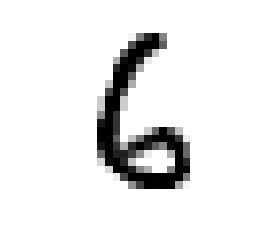

In [10]:
plt.imshow(digit_image,cmap=matplotlib.cm.binary,interpolation="nearest")
plt.axis("off")

This image looks like 6. Let us confirm it by looking at the target column:

In [11]:
y[41000]

6.0

### Splitting the data into Train and Test

In [12]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

We have split 60,000 images to training set and 10,000 to testing set. 

But most of them are in a specific order, this may affect while training a model. So let us shuffle them randomly.

In [13]:
shuffle_index = np.random.permutation(60000)
X_train,y_train = X_train[shuffle_index],y_train[shuffle_index]

## Training a binary classifier

Let us consider the problem as a simple binary classifier. We need to classify the digits as either 6 or not. 

Only two classes - 6 or not 6

LEt us create target vectors for this task:

In [14]:
y_train_6 = (y_train==6)
y_test_6 = (y_test==6)

#### Let us start by picking a Stochastic Gradient Descent (SGD) classifier, using Scikit-Learn’s SGDClassifier class.

The SGDClassifier relies on randomness during training (hence the name “stochastic”). If you want reproducible results, you should set the random_state parameter.

In [15]:
from sklearn.linear_model import SGDClassifier

In [16]:
sgd = SGDClassifier(random_state=36)
sgd.fit(X_train,y_train_6)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=36, shuffle=True,
       tol=None, verbose=0, warm_start=False)

Now let us test it on the above considered random digit:


In [17]:
sgd.predict([digit])

array([ True], dtype=bool)

So our classifier predicts correctly in this case.

## Performance Measures

### Cross-validation score

In [18]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd,X_train,y_train_6,cv=3,scoring="accuracy")

array([ 0.98360082,  0.974     ,  0.9819491 ])

### Confusion matrix

Let us first evaluate the prediction results:

In [19]:
from sklearn.model_selection import cross_val_predict

In [20]:
y_train_pred = cross_val_predict(sgd,X_train,y_train_6,cv=3)

In [21]:
from sklearn.metrics import confusion_matrix

In [22]:
confusion_matrix(y_train_6,y_train_pred)

array([[53733,   349],
       [  860,  5058]])

PRECISION - Among all the predictions, how many are correctly predicted as positive

RECALL - Among all the acutal positive instances, how many are correctly predicted

In [23]:
from sklearn.metrics import precision_score,recall_score,f1_score

In [24]:
precision_score(y_train_6,y_train_pred)

0.93545404105788788

In [25]:
5228/(5228+366)

0.9345727565248481

In [26]:
recall_score(y_train_6,y_train_pred)

0.85468063534978034

In [27]:
5228/(5228+690)

0.8834065562690098

#### So our classifier detects 88% of the 6 digits and when it claims a digit as 6, it is correct 93% of the time

In [28]:
f1_score(y_train_6,y_train_pred)

0.89324503311258285

### Tradeoff between Precision and Recall

There is always a tradeoff between Precision and Recall. If we want to increase the precision, recall decreases and vice versa.

For example, if you trained a classifier to detect videos that are safe for kids, you would probably prefer a classifier that rejects many good videos (low recall) but keeps only safe ones (high precision), rather than a classifier that has a much higher recall but lets a few really bad videos show up in your product.

On the other hand, suppose you train a classifier to detect shoplifters on surveillance images: it is probably fine if your classifier has only 30% precision as long as it has 99% recall (sure, the security guards will get a few false alerts, but almost all shoplifters will get caught).

#### So it depends on the purpose of the classifier. We need to choose a reasonable tradeoff

In [29]:
y_scores = cross_val_predict(sgd, X_train, y_train_6, cv=3, method="decision_function")

In [30]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_6, y_scores)

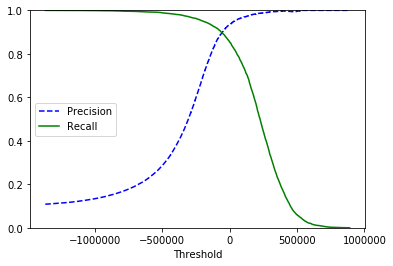

In [31]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="center left")
    plt.ylim([0, 1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

### Area under ROC Curve

The receiver operating characteristic (ROC) curve is another common tool used with binary classifiers. It is very similar to the precision/recall curve, but instead of plotting precision versus recall, the ROC curve plots the true positive rate (another name for recall) against the false positive rate.

In [32]:
from sklearn.metrics import roc_curve

In [33]:
fpr,tpr,thresholds = roc_curve(y_train_6,y_train_pred)

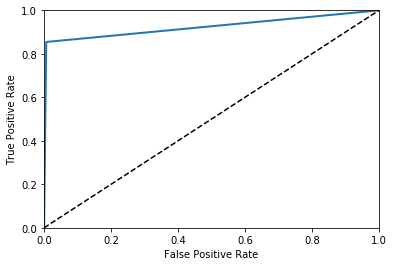

In [34]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(fpr, tpr)

One way to compare classifiers is to measure the area under the curve (AUC). A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5.

In [35]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_6,y_scores)

0.98786582811509027

## Multiclass classification

one way to create a system that can classify the digit images into 10 classes (from 0 to 9) is to train 10 binary classifiers, one for each digit (a 0-detector, a 1-detector, a 2-detector, and so on). Then when you want to classify an image, you get the decision score from each classifier for that image and you select the class whose classifier outputs the highest score. This is called the one-versus-all (OvA) strategy (also called one-versus-the-rest).

In [36]:
sgd.fit(X_train,y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=36, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [37]:
cross_val_score(sgd, X_train, y_train, cv=3, scoring="accuracy")

array([ 0.86327734,  0.86524326,  0.8479772 ])

### Scaling the inputs:


In [38]:
from sklearn.preprocessing import StandardScaler

In [39]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

In [40]:
cross_val_score(sgd, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([ 0.90786843,  0.91039552,  0.91113667])

In [41]:
y_train_pred = cross_val_predict(sgd,X_train_scaled,y_train,cv=3)
confusion_matrix(y_train,y_train_pred)

array([[5734,    3,   20,   10,   10,   49,   48,    9,   37,    3],
       [   2, 6488,   44,   28,    6,   45,    7,   13,   98,   11],
       [  50,   35, 5327,   93,   82,   26,  105,   55,  170,   15],
       [  46,   38,  137, 5352,    2,  239,   38,   54,  137,   88],
       [  22,   27,   36,    6, 5382,   11,   50,   29,   77,  202],
       [  82,   41,   32,  191,   78, 4594,  111,   26,  174,   92],
       [  28,   30,   43,    2,   35,  103, 5629,    8,   40,    0],
       [  25,   19,   70,   31,   55,    9,    7, 5810,   16,  223],
       [  49,  169,   72,  155,   16,  157,   56,   29, 5016,  132],
       [  46,   35,   28,   84,  165,   38,    2,  212,   83, 5256]])

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [43]:
precision_score(y_train,y_train_pred,average="macro")

0.90864137105100795

In [44]:
recall_score(y_train,y_train_pred,average="macro")

0.90854933692116191

In [46]:
from sklearn.metrics import accuracy_score

In [47]:
accuracy_score(y_train,y_train_pred)

0.90980000000000005